### Importando bibliotecas

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Baixando o MNIST e criando DataLoaders

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.07MB/s]


###  Criando a arquitetura do VAE

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Função de perda (com MSE e KL divergence)

In [4]:
def loss_function(recon_x, x, mu, logvar):
    # Erro de reconstrução
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL Divergência
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Treinamento

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 165.4918
Epoch 2, Loss: 121.6332
Epoch 3, Loss: 114.7367
Epoch 4, Loss: 111.7128
Epoch 5, Loss: 109.9228
Epoch 6, Loss: 108.6972
Epoch 7, Loss: 107.8434
Epoch 8, Loss: 107.2116
Epoch 9, Loss: 106.5866
Epoch 10, Loss: 106.2322


### Gerar imagens novas com VAE

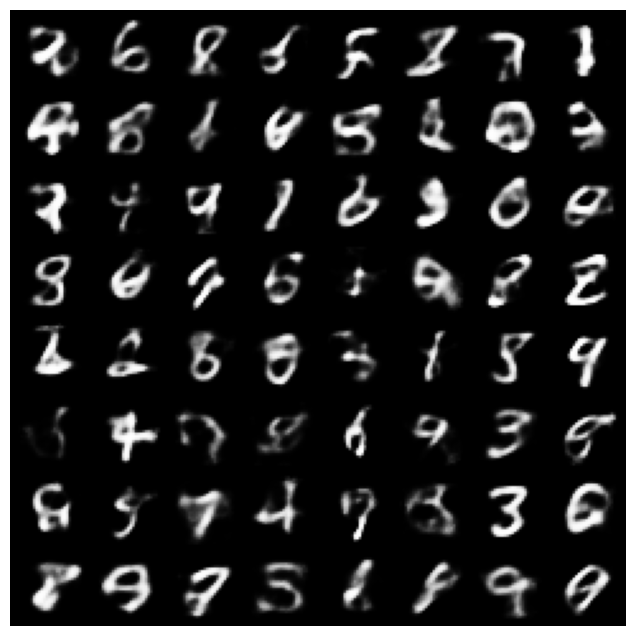

In [12]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 1, 28, 28)

    # Mostrar imagens geradas
    grid_img = torchvision.utils.make_grid(sample, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()